In [1]:
# LOAD PAKAGEEZimport pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 , glob , numpy , pdb
import os.path
import re
import html
from bs4 import BeautifulSoup
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from langdetect import detect_langs
import unicodedata

%matplotlib inline

In [2]:
df = pd.read_csv('dialogic.csv')
df= df[["physicallocationprovince","iscocode","iscodescription","typeofcontract","educationdegree","educationdegreeminimumrequired","workingexperienceindicator","basepaymin","basepaymax","selectedtextincludinghtml","educationdegreegeneralized","positionlanguage"]]
df.to_csv("dataframeclean.csv", encoding='utf-8', index=False)

C:\Programfiles\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
### CORRELATION VISUALIZATION
##HEATMAAAP BABY
plt.subplots(figsize=(20,15))
sns.heatmap(correlation_matrix,cmap='coolwarm',linewidths=1,vmin=-1, vmax=1)

In [ ]:
### MISSINGS VISUALIZATION
sns.heatmap(final_df.isnull(), cbar=False)

In [101]:
z= df["basepaymax"][(df["basepaymax"]<120000)]
sns.distplot(z,hist=False,bins=5,color='red')

In [132]:
df['totalwords'] = df['selectedtextincludinghtml'].str.split().str.len()
e= df["totalwords"][(df["totalwords"]<1000)]
sns.distplot(e,hist=False,bins=5,color='red')

In [172]:
##### CLEANING FURTHER BELOW HERE #########


df.to_csv("finalcleandf.csv", encoding='utf-8', index=False)
df = pd.read_csv('finalcleandf.csv')
df=df[df.basepaymax.notnull()]
df=df[(df["basepaymin"]<100000)]
df=df[(df["basepaymax"]<100000)]
df=df.reset_index(drop=True)

In [30]:
#### CREATE A MEAN FOR SALARY
cols = ["basepaymin","basepaymax"]
df['salary'] = df[cols].astype(float).mean(axis=1)
df.drop(["basepaymin", "basepaymax"], axis=1, inplace=True)

In [36]:
## RENAMING THE COLUMNS FOR EASIER READING
df.rename(columns={'physicallocationprovince':"province","educationdegree":"education","workingexperienceindicator":"experience",
                   'selectedtextincludinghtml':"description"},inplace=True)

In [42]:
## CLEANING EXPERIENCE COLUMN ####
df.loc[df["experience"] == "junior,medior,senior", "experience"] = "medior"
#ETSETSETSETSETS

In [8]:
df["experience"].value_counts()

medior    21004
junior     8618
senior     3864
Name: experience, dtype: int64

In [49]:
df["experience"]=df["experience"].fillna("medior")
df["experience"].isna().value_counts()

In [171]:
## CLEANING EDUCATION COLUMN 
df["education"].value_counts().nlargest(20)

HBO    21020
WO      8831
MBO     3634
Name: education, dtype: int64

In [165]:
df.loc[df["education"] == "VMBO", "education"] = "MBO"
#SAME AS EXPERIENCE, BLABLABLA LOOPILOOP

In [148]:
#FILL NA's FROM ANOTHER COL
list1=[]
for x,y in zip(df["education"],df["educationdegreeminimumrequired"]):
    if x=="onbekend":
        list1.append(y)
    else:
        list1.append(x)
df["education"]=list1

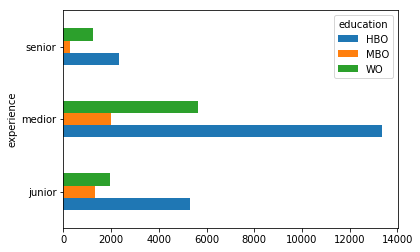

In [7]:
### VISUALIZATION AND CHECKPOINT #########

df.groupby("education").experience.value_counts().unstack(0).plot.barh()
df.to_csv("finalcleandf.csv", encoding='utf-8', index=False)


In [258]:
##### CLEANING THE DESCRIPTION TEXTUAL DATA DATA####### NOT DONE YET
df = pd.read_csv('finalcleandf.csv')

In [259]:
df=df.dropna(subset=["description"])
df['descriptionclean'] = df['description'].str.replace('<[^<]+?>', '')
df['descriptionclean'] = df['descriptionclean'].str.replace('\r', '')
df['descriptionclean'] = df['descriptionclean'].str.replace('\n', '')
df['descriptionclean'] = df['descriptionclean'].str.replace('&#246;', 'e')
df['descriptionclean'] = df['descriptionclean'].str.replace('&#233;', 'e')
df['descriptionclean'] = df['descriptionclean'].str.replace('&#235;', 'e')
df['descriptionclean'] = df['descriptionclean'].str.replace('&#8364;', '')
df['descriptionclean'] = df['descriptionclean'].str.replace('&#239;', 'i')
df['descriptionclean'] = df['descriptionclean'].str.replace('&#8226;', 'i')
df['descriptionclean'] = df['descriptionclean'].str.replace('&apos;', '')
df['descriptionclean'] = df['descriptionclean'].str.replace('#215;', '/')
df['descriptionclean'] = df['descriptionclean'].str.replace('&amp;', '')
df['descriptionclean'] = df['descriptionclean'].str.replace('&#8230;', '')
df['descriptionclean'] = df['descriptionclean'].str.replace('&#225;', '')
df['descriptionclean'] = df['descriptionclean'].str.replace('&quot;', '')


def strip_accents(text):

   
    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")

    return str(text)

df['descriptionclean'] = df['descriptionclean'].map(lambda x: strip_accents(str(x)))
df['descriptionclean'] = df['descriptionclean'].map(lambda x: re.sub(r'[^\x00-\x7F]+',' ', str(x)))


In [260]:
## FIRST ROUND OVER THE NON LABELED ITEMS
df1=df[(df["positionlanguage"].isna())]


def detectlang(string):
        string=str(string)
        res = detect_langs(string)
        for item in res:
            if item.lang == "nl" or item.lang == "en":
                return item.lang
            else:
                return "NONE"

df1["positionlanguage"]=df1["descriptionclean"].apply(detectlang)
df1=df1[(df1["positionlanguage"]=="nl")]

C:\Programfiles\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [261]:
df2=pd.concat([df, df1], ignore_index=True)
df=df2[(df2["positionlanguage"]=="nl")]
df.drop(["description","positionlanguage"], axis=1, inplace=True)
df.to_csv("finalcleandf.csv", encoding='utf-8', index=False)

## TEXT IS PRETTY CLEAN NOW, AFTER THIS NEED TO DO 
##  stuff like] and )(), ;":" 
##lower everything, 
## Save after this, afterwards we are going to split for extracting skills or not
## 1) NO DICTIONARY :tokenization, stopword removal, stemming/ dutch stemmer, LOG-TF/IDF,
## 2)WITH DICTIONARY: Build dictionary by hand and use stemmer without stemming the skills. 

In [2]:
######### ONE HOT ENCODING AND FINALIZING THE DATASET AS REQUIRED
##
df = pd.read_csv('finalcleandf.csv')
df.head()




,province,iscocode,iscodescription,typeofcontract,education,experience,salary,descriptionclean
0,Zuid-Holland,2511,Systeemanalisten,Fulltime,HBO,junior,49896.0,Applicatie Consultant (CRM) in heel NederlandR...
1,Noord-Brabant,2514,Applicatieprogrammeurs,Fulltime,HBO,junior,42120.0,1.025 / 1.379 vacatures CareerValue B.V. Vacat...
2,Friesland,2519,Software- en applicatieontwikkelaars en -anali...,Fulltime,HBO,medior,40357.5,TestanalistBenodigde opleiding: HBO Dienstverb...
3,Gelderland,2519,Software- en applicatieontwikkelaars en -anali...,"Fulltime,Parttime",WO,medior,38880.0,Medior Test Engineer 117348345 Functie-omschri...
4,Noord-Holland,3512,Technici voor informatie- en communicatietechn...,Fulltime,MBO,medior,46902.0,"Onderwijs Ondersteunende Dienst, Bussum Reguli..."


In [31]:
df["province"].value_counts()

Zuid-Holland     7386
Noord-Holland    6429
Utrecht          5699
Noord-Brabant    3816
Gelderland       3370
Overijssel       1285
Limburg           922
Groningen         852
Flevoland         507
Friesland         415
Drenthe           413
Zeeland           218
Name: province, dtype: int64

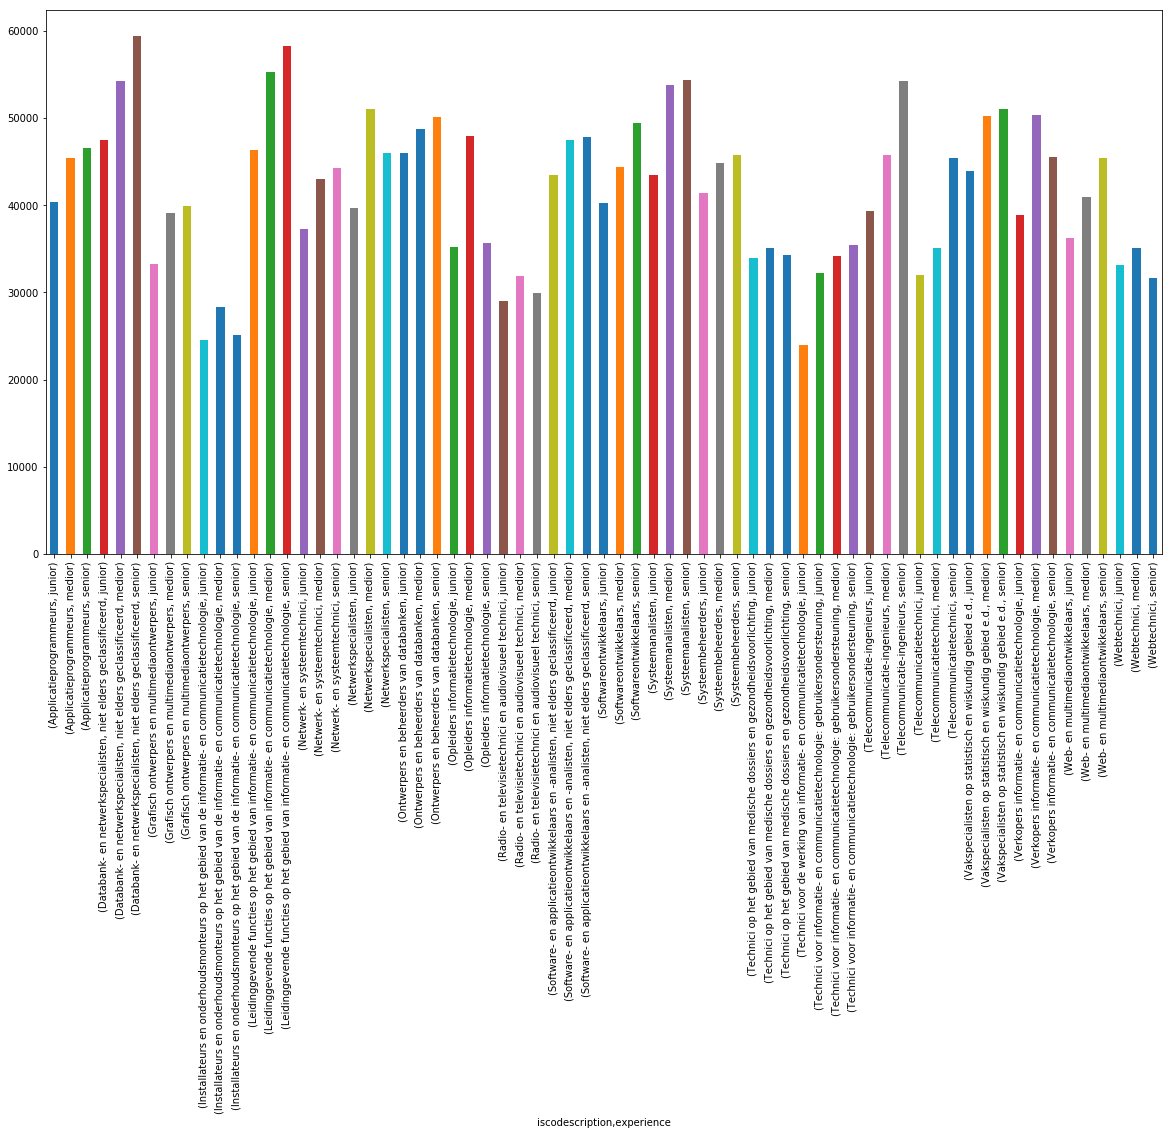

In [26]:
### EXPLORATORY CODE, isco code and description matches each other. JUST FOR MAD FUNZIS

df.groupby(["iscodescription","experience"])["salary"].mean().plot.bar(figsize=(20,10))


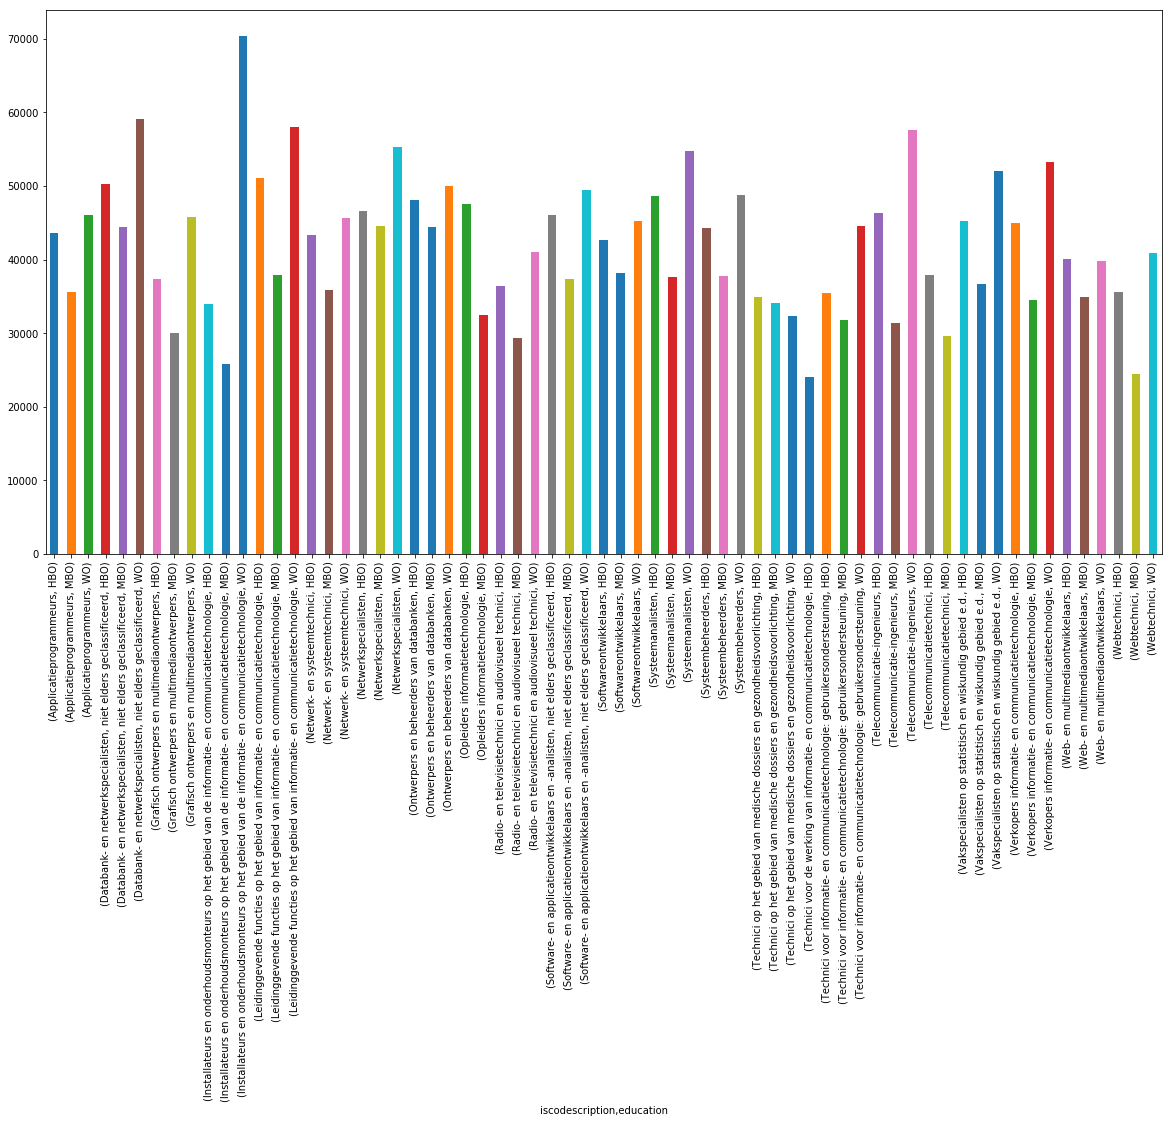

In [28]:
df.groupby(["iscodescription","education"])["salary"].mean().plot.bar(figsize=(20,10))


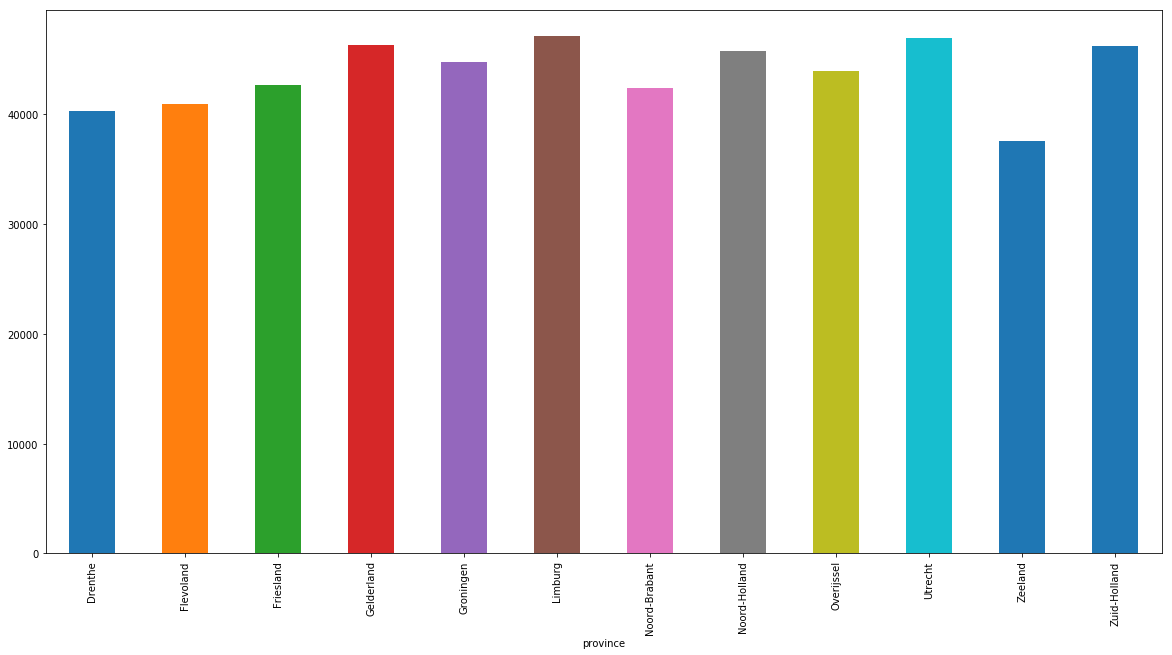

In [33]:
df.groupby("province")["salary"].mean().plot.bar(figsize=(20,10))


In [56]:
#nltk.download('stopwords') # If you just installed the package
#stopwords=set(stopwords.words('english'))
df["stopwords"]=df["descriptionclean"].dropna().apply(lambda x: sum([1 for w in x.split() if w.lower()  in stopwords]))


In [ ]:
####BACKUPCODE AND USEFULL CODE
##ONE HOT ENCODE
bins = [0, 25000,35000, 45000,60000,np.inf]
names = ["-25","25-35" ,'35-45', '45-60', '60+',]

df['salaryclass'] = pd.cut(df['salary'], bins, labels=names)
##############



import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # If you just installed the package
stopwords=set(stopwords.words('english'))
df["stopwords"]=df["descriptionclean"].dropna().apply(lambda x: sum([1 for w in x.split() if w.lower()  in stopwords]))


### POGING TAAL THE DETECTEREN#### GOING TO TAKE A LOT OF TIME
def languagedetect(text):
    try:
        return TextBlob(text).detect_language()
    except:
        return None



df["positionlanguage"]=df["descriptionclean"].apply(languagedetect)